# Convolutional Autoencoder

In [0]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

### Optional file unzip

In [0]:
import zipfile

UNZIP = False

if UNZIP:
    zip_ref = zipfile.ZipFile('files.zip', 'r')
    zip_ref.extractall('./')
    zip_ref.close()

### Import image

In [7]:
# Set path to the processed (40x40) images
IMGS_PATH = 'processedData.npy'

# Read the images
ImageMats = np.load(IMGS_PATH)
np.shape(ImageMats)

(10000, 1, 1600)

### Import labels

In [6]:
LABEL_PATH = "train_labels.csv"

Label_df = pd.read_csv(LABEL_PATH)
print(len(Label_df))
Label_df[0:3]

10000


,Id,Category
0,0,shovel
1,1,rifle
2,2,scorpion


## Pre-process
#### Get the images in 2D

In [8]:
# Array to store the images
Imgs_2Dset = np.empty((len(ImageMats),40,40))

for i in range(len(ImageMats)):
    Imgs_2Dset[i,:,:] = ImageMats[i].reshape((40,40))
    

np.shape(Imgs_2Dset)

(10000, 40, 40)

#### Manually add noise

In [8]:
# Manually add noise
N_NOISE = 600
NOISE_INTENSITY = 225

noisy_ImgSet = np.empty(np.shape(Imgs_2Dset))

for i, curImg in enumerate(Imgs_2Dset):
    # Generate noise locations
    noise_rowCoords = np.random.randint(0,40, N_NOISE)
    noise_colCoords = np.random.randint(0,40, N_NOISE)
    
    # Iterate over pixels to add noise
    noisy_curImg = np.copy(curImg)
    for j in range(N_NOISE):
        noisy_curImg[noise_rowCoords[j],noise_colCoords[j]] = NOISE_INTENSITY
        
    # Save picture
    noisy_ImgSet[i] = noisy_curImg


print(np.shape(noisy_ImgSet))

(10000, 40, 40)


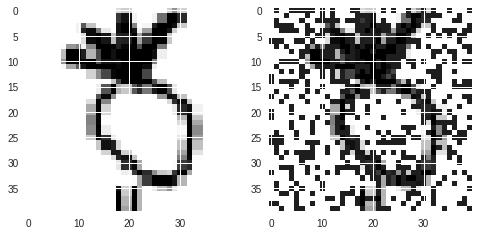

In [9]:
randIdx = 5

plt.subplot(1,2,1)
plt.imshow(Imgs_2Dset[randIdx], cmap='gray_r')
plt.subplot(1,2,2)
plt.imshow(noisy_ImgSet[randIdx], cmap='gray_r')
plt.show()

### Scale and shuffle data

In [10]:
# Scale clean data
clean_X_reDim = Imgs_2Dset / np.max(Imgs_2Dset)

# Scale noisy data
noisy_X_reDim = noisy_ImgSet / np.max(noisy_ImgSet)

# Shuffle both sets
from sklearn.utils import shuffle
clean_X_reDim, noisy_X_reDim = shuffle(clean_X_reDim, noisy_X_reDim, random_state=100)

print(np.shape(clean_X_reDim))
print(np.shape(noisy_X_reDim))

(10000, 40, 40)
(10000, 40, 40)


In [11]:
# Expand dimensions
clean_X = np.expand_dims(clean_X_reDim, axis=3)
print(np.shape(clean_X))

noisy_X = np.expand_dims(noisy_X_reDim, axis=3)
print(np.shape(noisy_X))

(10000, 40, 40, 1)
(10000, 40, 40, 1)


#### Split into training and test sets

In [20]:
from sklearn.model_selection import train_test_split
Xtrain_clean, Xtest_clean, Xtrain_noisy, Xtest_noisy = train_test_split(clean_X, noisy_X,
                                                                        test_size=0.40, 
                                                                        random_state=42)

print(np.shape(Xtrain_clean))
print(np.shape(Xtest_clean))
print(np.shape(Xtrain_noisy))
print(np.shape(Xtest_noisy))

(6000, 40, 40, 1)
(4000, 40, 40, 1)
(6000, 40, 40, 1)
(4000, 40, 40, 1)


# Auto-encoding

### Package import from tensorflow

In [0]:
from __future__ import print_function
import tensorflow as tf

import keras
from keras import layers

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Flatten
from keras.layers.normalization import BatchNormalization


### Define model
Tutorial: https://blog.keras.io/building-autoencoders-in-keras.html

Some guidance code: https://gist.github.com/naotokui/b9fb93b8dba534b55a140e8c88ce07f5

In [0]:
def convAutoencoder():
    input_img = Input(shape=(40, 40,1))  # adapt this if using `channels_first` image data format
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    
    autoencoder.summary()
    
    return autoencoder

In [26]:
conv_encoder = convAutoencoder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 32)        9248      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 20, 20, 32)        0         
__________

In [27]:
history = conv_encoder.fit(Xtrain_noisy, Xtrain_clean,
                           epochs=50,
                           batch_size=32,
                           shuffle=True,
                           validation_data=(Xtest_noisy, Xtest_clean)
                          )

Train on 6000 samples, validate on 4000 samples
Epoch 1/50
6000/6000 [==============================] - 4s 637us/step - loss: 0.0732 - val_loss: 0.0446
Epoch 2/50
6000/6000 [==============================] - 3s 549us/step - loss: 0.0376 - val_loss: 0.0329
Epoch 3/50
6000/6000 [==============================] - 3s 530us/step - loss: 0.0309 - val_loss: 0.0292
Epoch 4/50
6000/6000 [==============================] - 3s 571us/step - loss: 0.0271 - val_loss: 0.0279
Epoch 5/50
6000/6000 [==============================] - 4s 596us/step - loss: 0.0249 - val_loss: 0.0242
Epoch 6/50
6000/6000 [==============================] - 3s 537us/step - loss: 0.0232 - val_loss: 0.0240
Epoch 7/50
6000/6000 [==============================] - 3s 542us/step - loss: 0.0224 - val_loss: 0.0223
Epoch 8/50
6000/6000 [==============================] - 3s 540us/step - loss: 0.0218 - val_loss: 0.0236
Epoch 9/50
6000/6000 [==============================] - 3s 524us/step - loss: 0.0209 - val_loss: 0.0202
Epoch 10/50
6000

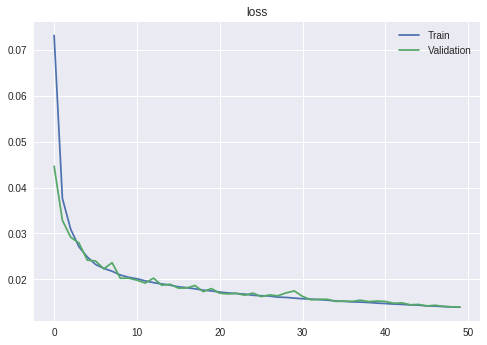

In [28]:
# Visualize loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("loss")
plt.legend(['Train','Validation'])
plt.show()

### Save model

In [0]:
# Save weights
import pickle

SAVE_MODEL = True
OUT_PATH = 'convAutoencoder.pickle'

if SAVE_MODEL:
    # Package the model and history
    outDict = {}
    outDict['model'] = conv_encoder
    outDict['history'] = history
    
    # Dump
    pickle.dump( outDict, open( OUT_PATH, "wb" ) )
    

# Load model and analyze

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
from __future__ import print_function
import tensorflow as tf

import keras
from keras import layers

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Flatten


/Users/anthony/anaconda3/envs/ImgCV/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load model pickle

In [4]:
import pickle

MODEL_DICT_PATH = '/Users/anthony/Documents/Comp551_Projects/Kaggle/autoencode_2018-11-26/convAutoencoder.pickle'

convAuto_dict = pickle.load( open( MODEL_DICT_PATH, "rb" ) )

#### Unpack model and training history

In [5]:
convDenoiser = convAuto_dict['model']
print(convDenoiser)

trHistory = convAuto_dict['history']
print(trHistory)

### Load images and add new noise
Can be ran independently from the blocks before the autoencoder training (since training might be done on CoLab)

In [9]:
# Set path to the processed (40x40) images
IMGS_PATH = '/Users/anthony/Documents/Comp551_Projects/Kaggle/theo_preprocessed/processedData.npy'

# Read the images
ImageMats = np.load(IMGS_PATH)
np.shape(ImageMats)

(10000, 1, 1600)

In [10]:
# Manually add noise
N_NOISE = 600
NOISE_INTENSITY = 225

noisy_ImgSet = np.empty(np.shape(Imgs_2Dset))

for i, curImg in enumerate(Imgs_2Dset):
    # Generate noise locations
    noise_rowCoords = np.random.randint(0,40, N_NOISE)
    noise_colCoords = np.random.randint(0,40, N_NOISE)
    
    # Iterate over pixels to add noise
    noisy_curImg = np.copy(curImg)
    for j in range(N_NOISE):
        noisy_curImg[noise_rowCoords[j],noise_colCoords[j]] = NOISE_INTENSITY
        
    # Save picture
    noisy_ImgSet[i] = noisy_curImg


print(np.shape(noisy_ImgSet))

(10000, 40, 40)


In [11]:
# Scale clean data
clean_X_reDim = Imgs_2Dset / np.max(Imgs_2Dset)

# Scale noisy data
noisy_X_reDim = noisy_ImgSet / np.max(noisy_ImgSet)

# Shuffle both sets
from sklearn.utils import shuffle
clean_X_reDim, noisy_X_reDim = shuffle(clean_X_reDim, noisy_X_reDim, random_state=100)

print(np.shape(clean_X_reDim))
print(np.shape(noisy_X_reDim))

(10000, 40, 40)
(10000, 40, 40)


In [12]:
# Expand dimensions
clean_X = np.expand_dims(clean_X_reDim, axis=3)
print(np.shape(clean_X))

noisy_X = np.expand_dims(noisy_X_reDim, axis=3)
print(np.shape(noisy_X))

(10000, 40, 40, 1)
(10000, 40, 40, 1)


## Predict and analyze
### Predict the noisy image set again for denoising

In [13]:
pred_clean_X = convDenoiser.predict(noisy_X)

np.shape(pred_clean_X)

(10000, 40, 40, 1)

### Analyze outcome

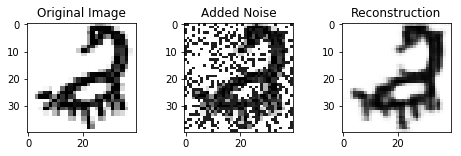

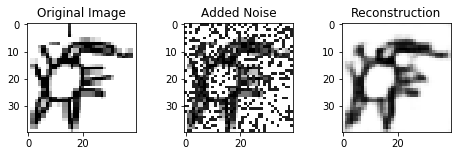

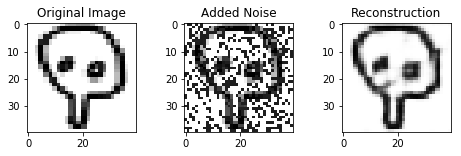

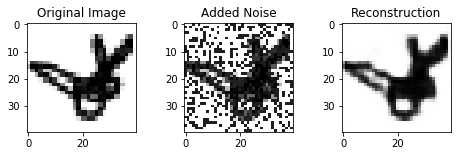

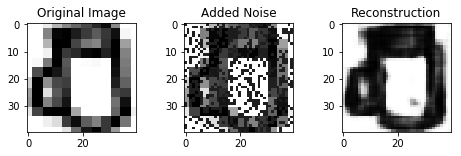

In [28]:
NUM_SAMPLE = 5

# Deterministically generate a few samples
rng = np.random.RandomState(seed=0)
randImg_indeces = rng.randint(0, len(ImageMats), size=NUM_SAMPLE)


for rand_i in randImg_indeces:
    plt.figure(figsize=(8, 2))
    plt.subplot(1,3,1)
    plt.imshow(clean_X[rand_i,:,:,0], cmap='gray_r')
    plt.title("Original Image")
    
    plt.subplot(1,3,2)
    plt.imshow(noisy_X[rand_i,:,:,0], cmap='gray_r')
    plt.title("Added Noise")
    
    plt.subplot(1,3,3)
    plt.imshow(pred_clean_X[rand_i,:,:,0], cmap='gray_r')
    plt.title("Reconstruction")
    plt.show()

## Apply the denoiser to the clean image

In [19]:
cleaner_X = convDenoiser.predict(clean_X)

np.shape(cleaner_X)

(10000, 40, 40, 1)

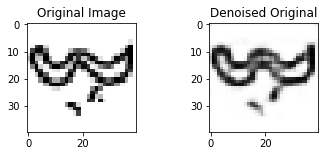

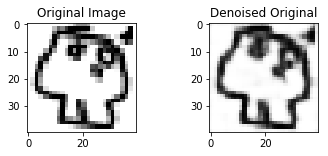

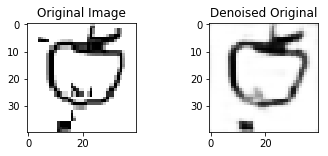

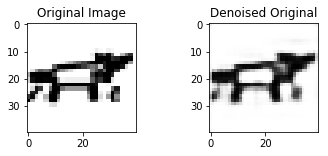

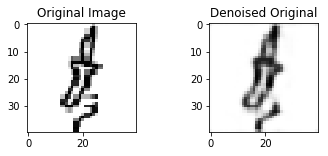

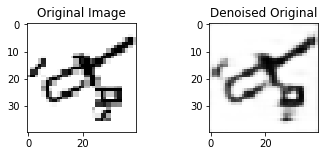

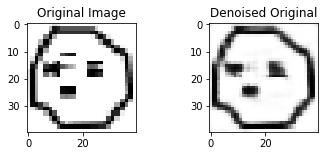

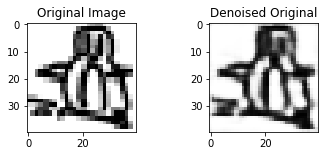

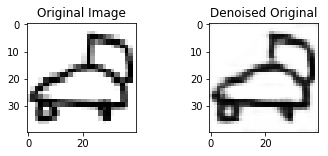

In [26]:
NUM_SAMPLE = 9

# Deterministically generate a few samples
rng = np.random.RandomState(seed=42)
randImg_indeces = rng.randint(0, len(ImageMats), size=NUM_SAMPLE)


for rand_i in randImg_indeces:
    plt.figure(figsize=(6, 2))
    
    plt.subplot(1,2,1)
    plt.imshow(clean_X[rand_i,:,:,0], cmap='gray_r')
    plt.title("Original Image")
    
    plt.subplot(1,2,2)
    plt.imshow(cleaner_X[rand_i,:,:,0], cmap='gray_r')
    plt.title("Denoised Original")
    
    plt.show()